# General imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [3]:
# Load the data
df = pd.read_csv('data.csv')

# Create data frame

In [4]:
df.head()

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD
0,1,01 ONE FAMILY HOMES,1,S1,15 AVENUE D,10009.0,1.0,1.0,826.0,2240.0,1,S1,593362.0,40.720574,-73.978498,2010,4
1,1,02 TWO FAMILY HOMES,1,S2,91 AVENUE D,10009.0,2.0,1.0,994.0,3799.0,1,S2,1320000.0,40.723029,-73.976691,2010,2
2,1,03 THREE FAMILY HOMES,1,C0,326 EAST 4TH STREET,10009.0,3.0,0.0,2204.0,3921.0,1,C0,900000.0,40.721776,-73.979224,2010,12
3,1,04 TAX CLASS 1 CONDOS,1C,R6,238 EAST 4TH STREET,10009.0,1.0,0.0,0.0,0.0,1,R6,3027375.0,40.723353,-73.982947,2010,8
4,1,07 RENTALS - WALKUP APARTMENTS,2,C7,11 AVENUE D,10009.0,16.0,3.0,3419.0,14400.0,2,C7,8000000.0,40.720526,-73.978628,2010,2


# Clean data frame

In [5]:
# Convert values to numeric
df['ZIP CODE'] = pd.to_numeric(df['ZIP CODE'], errors='coerce')
df['RESIDENTIAL UNITS'] = pd.to_numeric(df['RESIDENTIAL UNITS'], errors='coerce')
df['COMMERCIAL UNITS'] = pd.to_numeric(df['COMMERCIAL UNITS'], errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

# Label encoding
label_encoder = preprocessing.LabelEncoder()
df['NEIGHBORHOOD'] = label_encoder.fit_transform(df['NEIGHBORHOOD'])

In [6]:
# Convert PRICES to
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

# Convert GROSS SQUARE FEET column values to numeric
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [7]:
null_values = df.isna()

pct_null = (null_values.mean() * 100).round(10)

print("Percentage of null values:")
print(pct_null)

Percentage of null values:
NEIGHBORHOOD                      0.0
BUILDING CLASS CATEGORY           0.0
TAX CLASS AT PRESENT              0.0
BUILDING CLASS AT PRESENT         0.0
ADDRESS                           0.0
ZIP CODE                          0.0
RESIDENTIAL UNITS                 0.0
COMMERCIAL UNITS                  0.0
LAND SQUARE FEET                  0.0
GROSS SQUARE FEET                 0.0
TAX CLASS AT TIME OF SALE         0.0
BUILDING CLASS AT TIME OF SALE    0.0
SALE PRICE                        0.0
LATITUDE                          0.0
LONGITUDE                         0.0
YEAR_SOLD                         0.0
MONTH_SOLD                        0.0
dtype: float64


In [8]:
df.shape

(311283, 17)

In [9]:
print(df.dtypes)


NEIGHBORHOOD                        int64
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
ZIP CODE                          float64
RESIDENTIAL UNITS                 float64
COMMERCIAL UNITS                  float64
LAND SQUARE FEET                  float64
GROSS SQUARE FEET                 float64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
LATITUDE                          float64
LONGITUDE                         float64
YEAR_SOLD                           int64
MONTH_SOLD                          int64
dtype: object


In [10]:
# Contar o número de NaN por coluna
print(df.isna().sum())

NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
LATITUDE                          0
LONGITUDE                         0
YEAR_SOLD                         0
MONTH_SOLD                        0
dtype: int64


In [11]:
df.describe()

,NEIGHBORHOOD,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD
count,311283.000000,311283.000000,311283.000000,311283.000000,311283.000000,311283.000000,311283.000000,3.112830e+05,311283.000000,311283.000000,311283.000000,311283.000000
mean,45.548549,10029.359117,1.785372,0.347227,797.793224,6387.181835,2.300627,2.282422e+06,40.672223,-73.367703,2010.510025,6.589380
std,20.993594,38.170134,13.351147,4.000125,3591.966286,27904.025884,0.749531,9.621848e+06,2.561457,12.066826,4.952774,3.356937
min,0.000000,10001.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,-46.598362,-165.106380,2003.000000,1.000000
25%,24.000000,10014.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.750000e+05,40.754993,-73.983179,2006.000000,4.000000
50%,49.000000,10021.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.490000e+05,40.774166,-73.967596,2010.000000,7.000000
75%,63.000000,10026.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.625000e+06,40.777048,-73.967596,2015.000000,9.000000
max,76.000000,10463.000000,764.000000,570.000000,149560.000000,420000.000000,4.000000,3.000000e+08,64.843318,176.164822,2023.000000,12.000000


# Filter coordinates outside Manhattan. (Used Geocodify API so there can be errors)

In [12]:
from shapely.geometry import Point, Polygon

def FilterManhattanCoordinates(df):
    # These coordinates form a polygon that approximates Manhattan's shape
    MANHATTAN_CORDS = [
        (40.698005, -74.016173),
        (40.704772, -74.021498),
        (40.756209, -74.012266),
        (40.878978, -73.929209),
        (40.875195, -73.918612),
        (40.872910, -73.909668),
        (40.863531, -73.914005),
        (40.846438, -73.927714),
        (40.834556, -73.934069),
        (40.808835, -73.933640),
        (40.800519, -73.927370),
        (40.792851, -73.929260),
        (40.781284, -73.940080),
        (40.775369, -73.940080),
        (40.741822, -73.970742),
        (40.728637, -73.964892),
        (40.710145, -73.975104),
        (40.705981, -73.997177),
        (40.699799, -74.004993),
        (40.698005, -74.016173)  # Back to start
    ]

    MANHATTAN_POLY = Polygon(MANHATTAN_CORDS)

    # Create a mask for points within Manhattan
    def IsInManhattan(row):
        point = Point(row['LATITUDE'], row['LONGITUDE'])
        return MANHATTAN_POLY.contains(point)

    # Apply the filter
    manhattan_mask = df.apply(IsInManhattan, axis=1)
    manhattan_df = df[manhattan_mask].copy()

    return manhattan_df

# Filter coordinates outside Manhattan
df = FilterManhattanCoordinates(df)

# Display graphics

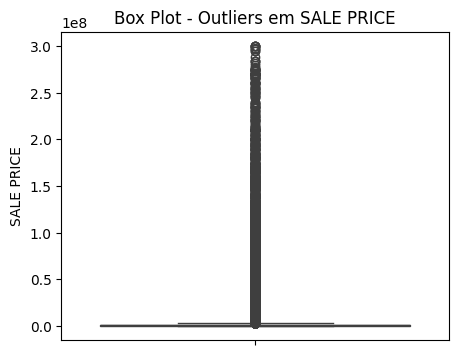

In [13]:
plt.figure(figsize=(5, 4))
sns.boxplot(y=df["SALE PRICE"])
plt.title("Box Plot - Outliers em SALE PRICE")
plt.ylabel("SALE PRICE")
plt.show()

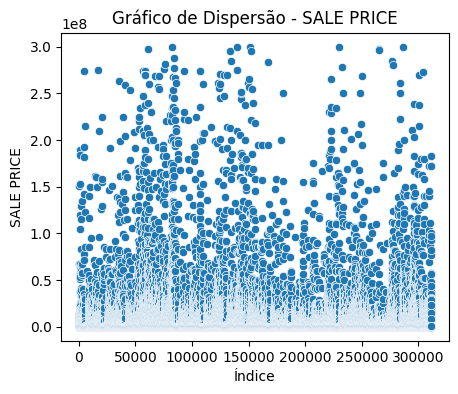

In [14]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x=df.index, y=df["SALE PRICE"])
plt.title("Gráfico de Dispersão - SALE PRICE")
plt.xlabel("Índice")
plt.ylabel("SALE PRICE")
plt.show()


In [15]:
df.shape

(304861, 17)

In [16]:
free_properties = df[df['SALE PRICE'] <= 10000]
free_properties.shape

(7297, 17)

In [17]:
df = df[df['SALE PRICE'] > 10000]
df.shape

(297564, 17)

In [18]:
df.columns

Index(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'LATITUDE', 'LONGITUDE', 'YEAR_SOLD', 'MONTH_SOLD'],
      dtype='object')

In [19]:
df.nunique()


NEIGHBORHOOD                          77
BUILDING CLASS CATEGORY              136
TAX CLASS AT PRESENT                  11
BUILDING CLASS AT PRESENT            171
ADDRESS                           143193
ZIP CODE                              70
RESIDENTIAL UNITS                    286
COMMERCIAL UNITS                     119
LAND SQUARE FEET                    4683
GROSS SQUARE FEET                  10029
TAX CLASS AT TIME OF SALE              4
BUILDING CLASS AT TIME OF SALE       175
SALE PRICE                         45852
LATITUDE                           22362
LONGITUDE                          21597
YEAR_SOLD                             21
MONTH_SOLD                            12
dtype: int64

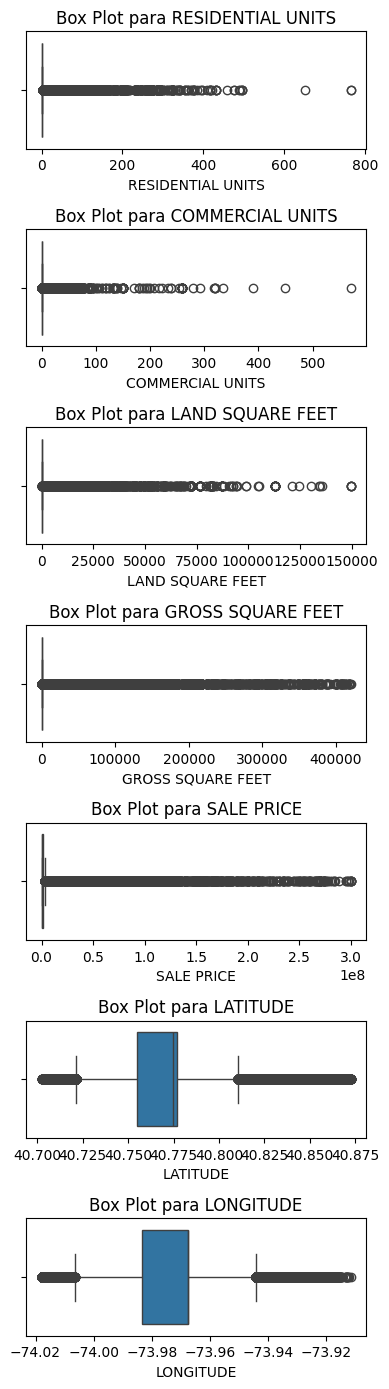

In [20]:

# Selecionar apenas as colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

numeric_df = numeric_df.drop(columns=['ZIP CODE', 'NEIGHBORHOOD', 'MONTH_SOLD', 'YEAR_SOLD', 'TAX CLASS AT TIME OF SALE'])

# Definir o número de subplots
num_cols = len(numeric_df.columns)
fig, axes = plt.subplots(nrows=num_cols, figsize=(4, 2*num_cols))

# Criar um box plot para cada coluna numérica
for i, col in enumerate(numeric_df.columns):
    sns.boxplot(x=numeric_df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot para {col}')

plt.tight_layout()
plt.show()


In [21]:
for col in df.columns:
    print(f"valores igual a 0: {col} = {df[df[col] == 0].shape[0]}")

valores igual a 0: NEIGHBORHOOD = 391
valores igual a 0: BUILDING CLASS CATEGORY = 0
valores igual a 0: TAX CLASS AT PRESENT = 0
valores igual a 0: BUILDING CLASS AT PRESENT = 0
valores igual a 0: ADDRESS = 0
valores igual a 0: ZIP CODE = 0
valores igual a 0: RESIDENTIAL UNITS = 167338
valores igual a 0: COMMERCIAL UNITS = 256267
valores igual a 0: LAND SQUARE FEET = 260351
valores igual a 0: GROSS SQUARE FEET = 258181
valores igual a 0: TAX CLASS AT TIME OF SALE = 0
valores igual a 0: BUILDING CLASS AT TIME OF SALE = 0
valores igual a 0: SALE PRICE = 0
valores igual a 0: LATITUDE = 0
valores igual a 0: LONGITUDE = 0
valores igual a 0: YEAR_SOLD = 0
valores igual a 0: MONTH_SOLD = 0


In [22]:
# show the unique values in "neighborhood" column
df['NEIGHBORHOOD'].unique()

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 45, 47, 49, 51, 53, 56, 58, 60, 62, 64, 66, 68,
       70, 72, 74, 76, 25, 27, 29, 31, 33, 35, 37, 39, 41, 44, 46, 48, 52,
       55, 57, 59, 61, 63, 67, 69, 71, 73, 75,  0,  2,  4,  6,  8, 10, 12,
       14, 16, 18, 21, 23, 50, 54, 65, 43])

In [23]:
import pandas as pd

# Supondo que o seu DataFrame se chame df
# e que as colunas se chamem exatamente 'LAND SQUARE FEET' e 'GROSS SQUARE FEET'
linhas_zeros = df[(df['LAND SQUARE FEET'] == 0) & (df['GROSS SQUARE FEET'] == 0)].shape[0]

print("Número de linhas onde ambos LAND SQUARE FEET e GROSS SQUARE FEET são 0:", linhas_zeros)


Número de linhas onde ambos LAND SQUARE FEET e GROSS SQUARE FEET são 0: 257028


In [24]:
df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD
0,1,01 ONE FAMILY HOMES,1,S1,15 AVENUE D,10009.0,1.0,1.0,826.0,2240.0,1,S1,593362.0,40.720574,-73.978498,2010,4
1,1,02 TWO FAMILY HOMES,1,S2,91 AVENUE D,10009.0,2.0,1.0,994.0,3799.0,1,S2,1320000.0,40.723029,-73.976691,2010,2
2,1,03 THREE FAMILY HOMES,1,C0,326 EAST 4TH STREET,10009.0,3.0,0.0,2204.0,3921.0,1,C0,900000.0,40.721776,-73.979224,2010,12
3,1,04 TAX CLASS 1 CONDOS,1C,R6,238 EAST 4TH STREET,10009.0,1.0,0.0,0.0,0.0,1,R6,3027375.0,40.723353,-73.982947,2010,8
4,1,07 RENTALS - WALKUP APARTMENTS,2,C7,11 AVENUE D,10009.0,16.0,3.0,3419.0,14400.0,2,C7,8000000.0,40.720526,-73.978628,2010,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311278,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 1",10029.0,8.0,2.0,2523.0,9750.0,2,C7,42500.0,40.777048,-73.967596,2023,12
311279,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 3",10029.0,8.0,2.0,2523.0,9750.0,2,C7,42500.0,40.777048,-73.967596,2023,12
311280,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 4",10029.0,8.0,2.0,2523.0,9750.0,2,C7,248854.0,40.777048,-73.967596,2023,12
311281,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 5",10029.0,8.0,2.0,2523.0,9750.0,2,C7,248854.0,40.777048,-73.967596,2023,12


In [25]:
df = df.drop(df[df["LAND SQUARE FEET"] > 170_000].index)
df = df.drop(df[df["GROSS SQUARE FEET"] > 420_000].index)
df = df.drop(df[df["COMMERCIAL UNITS"] > 1000].index)
df = df.drop(df[df["RESIDENTIAL UNITS"] > 6000].index)

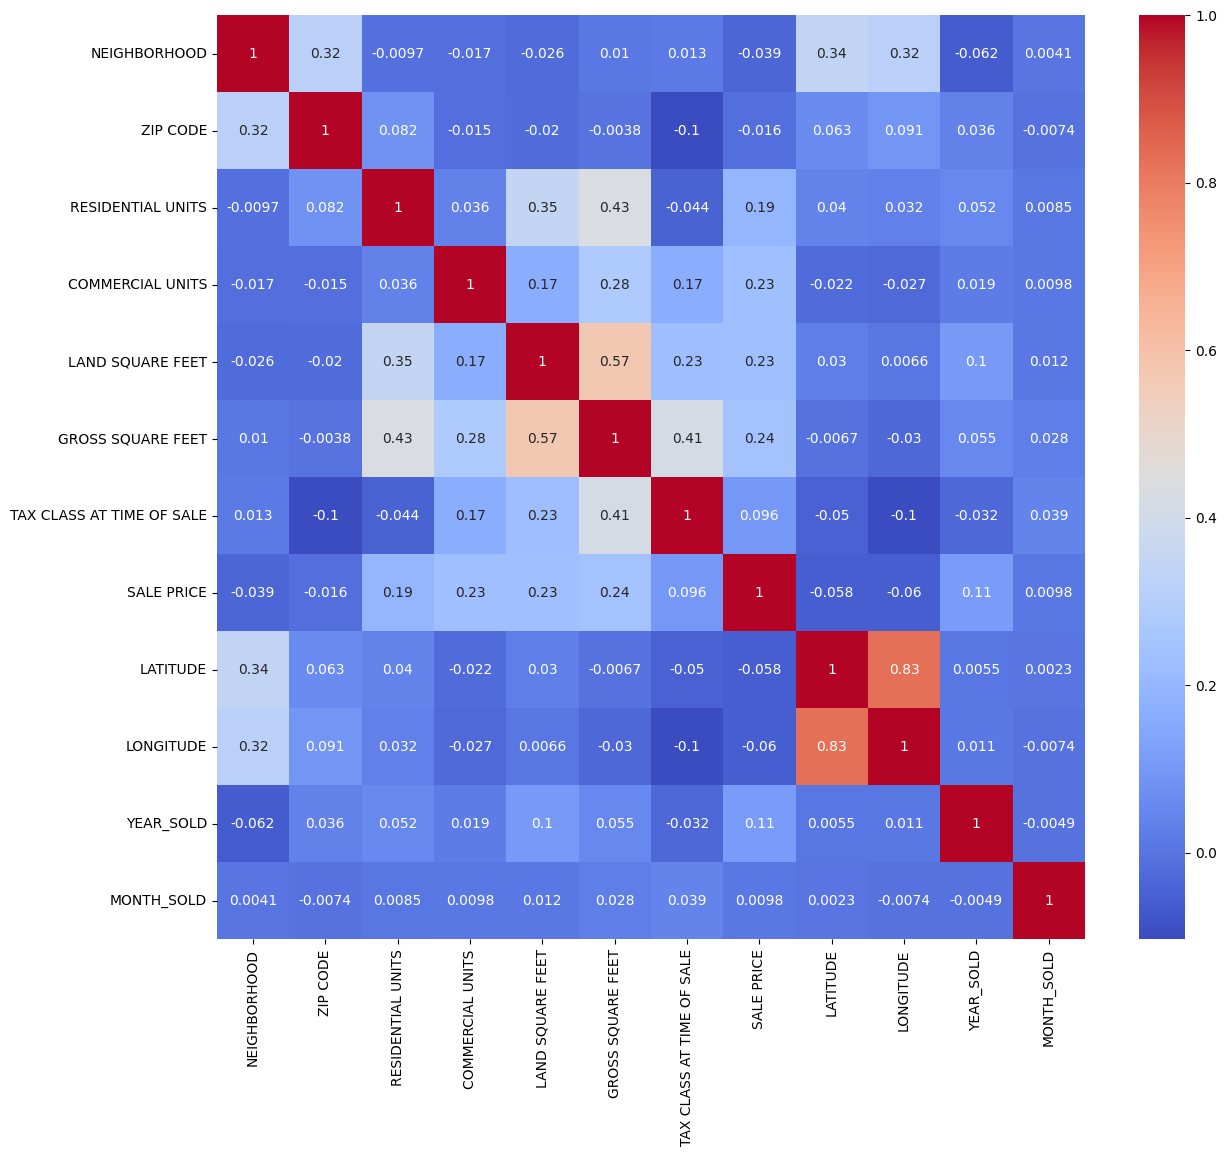

In [26]:
numeric_df = df.select_dtypes(include=['number'])

# Calcular a correlação e criar o heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [27]:
df.columns

Index(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'LATITUDE', 'LONGITUDE', 'YEAR_SOLD', 'MONTH_SOLD'],
      dtype='object')

In [39]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 297564 entries, 0 to 311282
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   NEIGHBORHOOD                    297564 non-null  int64  
 1   BUILDING CLASS CATEGORY         297564 non-null  object 
 2   TAX CLASS AT PRESENT            297564 non-null  object 
 3   BUILDING CLASS AT PRESENT       297564 non-null  object 
 4   ADDRESS                         297564 non-null  object 
 5   ZIP CODE                        297564 non-null  float64
 6   RESIDENTIAL UNITS               297564 non-null  float64
 7   COMMERCIAL UNITS                297564 non-null  float64
 8   LAND SQUARE FEET                297564 non-null  float64
 9   GROSS SQUARE FEET               297564 non-null  float64
 10  TAX CLASS AT TIME OF SALE       297564 non-null  int64  
 11  BUILDING CLASS AT TIME OF SALE  297564 non-null  object 
 12  SALE PRICE           

In [28]:
df_ano = df.groupby(df["YEAR_SOLD"])["SALE PRICE"].mean().reset_index()

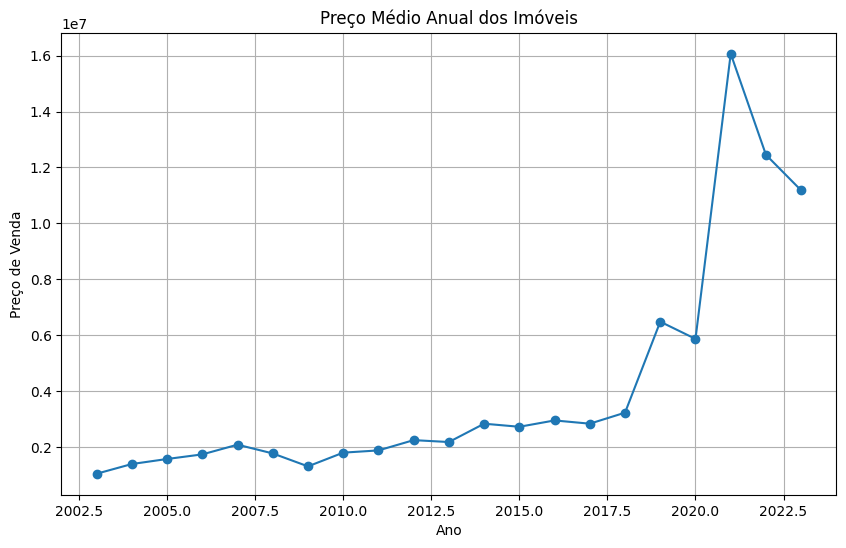

In [29]:
# Cria o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(df_ano["YEAR_SOLD"], df_ano["SALE PRICE"], marker='o', linestyle='-')
plt.title("Preço Médio Anual dos Imóveis")
plt.xlabel("Ano")
plt.ylabel("Preço de Venda")
plt.grid(True)
plt.show()

In [30]:
# Check NA 'LATITUDE' and 'LONGITUDE' rows
df[df['LATITUDE'].isna() & df['LONGITUDE'].isna()]

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD


In [31]:
import plotly.express as px

# First group the data to count sales at each coordinate
location_counts = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'ADDRESS': 'first',  # Keep one address for hover info
    'SALE PRICE': 'count',  # Count number of sales
}).reset_index()

# Rename the count column for clarity
location_counts = location_counts.rename(columns={'SALE PRICE': 'Number of Sales'})

# Create the interactive map
fig = px.scatter_map(
    location_counts,
    lat="LATITUDE",
    lon="LONGITUDE",
    hover_name="ADDRESS",
    hover_data=["Number of Sales"],
    color="Number of Sales",  # Color now based on number of sales
    color_continuous_scale="inferno",  # Keep your original color scale
    size="Number of Sales",  # Make point size reflect number of sales
    size_max=15,  # Adjust maximum size of points
    zoom=10,
    height=600
)

# Map configurations (keeping your original settings)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
fig.update_layout(title="Map of Sales Frequency")

# Show the plot
fig.show()


In [32]:
# Also delete a row which coordinates falls inside Central Park
# df = df.drop(df[df['LATITUDE'].round(5) == 40.77705].index)

df[(df['LATITUDE'] == 40.777048) & (df['LONGITUDE'] == -73.967596)]

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD
19,1,09 COOPS - WALKUP APARTMENTS,2,C6,"206 EAST 7TH STREET, 1920",10009.0,0.0,0.0,0.0,0.0,2,C6,518950.0,40.777048,-73.967596,2010,2
20,1,09 COOPS - WALKUP APARTMENTS,2,C6,"633 EAST 11 STREET, 10",10009.0,0.0,0.0,0.0,0.0,2,C6,400000.0,40.777048,-73.967596,2010,2
21,1,09 COOPS - WALKUP APARTMENTS,2,C6,"633 EAST 11TH STREET, 2",10009.0,0.0,0.0,0.0,0.0,2,C6,420000.0,40.777048,-73.967596,2010,4
24,1,09 COOPS - WALKUP APARTMENTS,2,C6,"527 EAST 12TH, A6",10009.0,0.0,0.0,0.0,0.0,2,C6,336000.0,40.777048,-73.967596,2010,1
25,1,09 COOPS - WALKUP APARTMENTS,2,C6,"507 EAST 12TH STREET, 3A",10009.0,0.0,0.0,0.0,0.0,2,C6,420000.0,40.777048,-73.967596,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311278,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 1",10029.0,8.0,2.0,2523.0,9750.0,2,C7,42500.0,40.777048,-73.967596,2023,12
311279,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 3",10029.0,8.0,2.0,2523.0,9750.0,2,C7,42500.0,40.777048,-73.967596,2023,12
311280,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 4",10029.0,8.0,2.0,2523.0,9750.0,2,C7,248854.0,40.777048,-73.967596,2023,12
311281,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 5",10029.0,8.0,2.0,2523.0,9750.0,2,C7,248854.0,40.777048,-73.967596,2023,12


In [33]:
df.shape

(297564, 17)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297564 entries, 0 to 311282
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   NEIGHBORHOOD                    297564 non-null  int64  
 1   BUILDING CLASS CATEGORY         297564 non-null  object 
 2   TAX CLASS AT PRESENT            297564 non-null  object 
 3   BUILDING CLASS AT PRESENT       297564 non-null  object 
 4   ADDRESS                         297564 non-null  object 
 5   ZIP CODE                        297564 non-null  float64
 6   RESIDENTIAL UNITS               297564 non-null  float64
 7   COMMERCIAL UNITS                297564 non-null  float64
 8   LAND SQUARE FEET                297564 non-null  float64
 9   GROSS SQUARE FEET               297564 non-null  float64
 10  TAX CLASS AT TIME OF SALE       297564 non-null  int64  
 11  BUILDING CLASS AT TIME OF SALE  297564 non-null  object 
 12  SALE PRICE           

In [44]:
features = df.drop(columns=['SALE PRICE']).columns
features


Index(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'LATITUDE', 'LONGITUDE', 'YEAR_SOLD', 'MONTH_SOLD'],
      dtype='object')

In [48]:
df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD
0,1,01 ONE FAMILY HOMES,1,S1,15 AVENUE D,10009.0,1.0,1.0,826.0,2240.0,1,S1,593362.0,40.720574,-73.978498,2010,4
1,1,02 TWO FAMILY HOMES,1,S2,91 AVENUE D,10009.0,2.0,1.0,994.0,3799.0,1,S2,1320000.0,40.723029,-73.976691,2010,2
2,1,03 THREE FAMILY HOMES,1,C0,326 EAST 4TH STREET,10009.0,3.0,0.0,2204.0,3921.0,1,C0,900000.0,40.721776,-73.979224,2010,12
3,1,04 TAX CLASS 1 CONDOS,1C,R6,238 EAST 4TH STREET,10009.0,1.0,0.0,0.0,0.0,1,R6,3027375.0,40.723353,-73.982947,2010,8
4,1,07 RENTALS - WALKUP APARTMENTS,2,C7,11 AVENUE D,10009.0,16.0,3.0,3419.0,14400.0,2,C7,8000000.0,40.720526,-73.978628,2010,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311278,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 1",10029.0,8.0,2.0,2523.0,9750.0,2,C7,42500.0,40.777048,-73.967596,2023,12
311279,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 3",10029.0,8.0,2.0,2523.0,9750.0,2,C7,42500.0,40.777048,-73.967596,2023,12
311280,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 4",10029.0,8.0,2.0,2523.0,9750.0,2,C7,248854.0,40.777048,-73.967596,2023,12
311281,25,07 RENTALS - WALKUP APARTMENTS,2B,C7,"152 EAST 116TH STREET, 5",10029.0,8.0,2.0,2523.0,9750.0,2,C7,248854.0,40.777048,-73.967596,2023,12


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Select features for prediction
features = df.drop(columns=['SALE PRICE', 'ADDRESS', 'BUILDING CLASS CATEGORY', 'BUILDING CLASS AT TIME OF SALE', 
                            'TAX CLASS AT TIME OF SALE', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT']).columns
X = df[features]
y = df['SALE PRICE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'RMSE': rmse,
        'R2': r2
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"RMSE: {metrics['RMSE']:,.2f}")
    print(f"R2: {metrics['R2']:.4f}")


Linear Regression:
RMSE: 9,440,905.36
R2: 0.1112

Ridge:
RMSE: 9,440,901.11
R2: 0.1112

Lasso:
RMSE: 9,440,905.26
R2: 0.1112

Random Forest:
RMSE: 6,515,769.60
R2: 0.5767

Gradient Boosting:
RMSE: 8,007,590.16
R2: 0.3606


In [54]:
# Use the best performing model (Random Forest) with the best parameters
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    bootstrap=True,
    random_state=42
)

# Train the model on all data
best_rf.fit(X, y)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Print feature importance
print("Feature Importance:")
print(feature_importance)

# Function to make predictions
def predict_sale_price(model, features_dict):
    """
    Make predictions using the trained model
    
    Args:
        model: Trained RandomForestRegressor model
        features_dict: Dictionary with feature values
        
    Returns:
        Predicted sale price
    """
    # Create a DataFrame with the input features
    input_df = pd.DataFrame([features_dict])
    
    # Make prediction
    predicted_price = model.predict(input_df)[0]
    
    return predicted_price

Feature Importance:
             feature  importance
5  GROSS SQUARE FEET    0.270486
6           LATITUDE    0.140406
8          YEAR_SOLD    0.106383
7          LONGITUDE    0.092841
2  RESIDENTIAL UNITS    0.084702
4   LAND SQUARE FEET    0.077908
1           ZIP CODE    0.069615
3   COMMERCIAL UNITS    0.055766
9         MONTH_SOLD    0.054859
0       NEIGHBORHOOD    0.047034


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Feature engineering
def create_features(X):
    X_new = X.copy()
    
    # Create price per square foot features
    X_new['PRICE_PER_GROSS_SQFT'] = X_new['GROSS SQUARE FEET'].apply(lambda x: 1 if x == 0 else x)
    X_new['PRICE_PER_LAND_SQFT'] = X_new['LAND SQUARE FEET'].apply(lambda x: 1 if x == 0 else x)
    
    # Create unit density features
    X_new['TOTAL_UNITS'] = X_new['RESIDENTIAL UNITS'] + X_new['COMMERCIAL UNITS']
    X_new['UNIT_DENSITY'] = X_new['TOTAL_UNITS'] / X_new['PRICE_PER_GROSS_SQFT']
    
    # Create location based features
    X_new['DISTANCE_TO_CENTER'] = np.sqrt(
        (X_new['LATITUDE'] - X_new['LATITUDE'].mean())**2 + 
        (X_new['LONGITUDE'] - X_new['LONGITUDE'].mean())**2
    )
    
    return X_new

# Prepare features
X_engineered = create_features(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_engineered)
X_scaled = pd.DataFrame(X_scaled, columns=X_engineered.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create optimized Random Forest model
rf_optimized = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# Train model
rf_optimized.fit(X_train, y_train)

# Make predictions
y_pred = rf_optimized.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: ${rmse:,.2f}")
print(f"R2 Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_engineered.columns,
    'importance': rf_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

RMSE: $6,402,930.95
R2 Score: 0.5912

Top 10 Most Important Features:
                 feature  importance
10  PRICE_PER_GROSS_SQFT    0.106040
5      GROSS SQUARE FEET    0.097094
8              YEAR_SOLD    0.091594
6               LATITUDE    0.090892
14    DISTANCE_TO_CENTER    0.088447
7              LONGITUDE    0.078292
4       LAND SQUARE FEET    0.058968
11   PRICE_PER_LAND_SQFT    0.057696
9             MONTH_SOLD    0.056265
1               ZIP CODE    0.051588
